In [1]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


# DATA COLLECTION

## SNP , RFR , Trading Days

In [2]:
query_start_date = '2000-01-01'

In [3]:
risk_free_data = conn.raw_sql(f'''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '{query_start_date}'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,2000-01-03,0.00021
1,2000-01-04,0.00021
2,2000-01-05,0.00021
3,2000-01-06,0.00021
4,2000-01-07,0.00021
...,...,...
6243,2024-10-25,0.00017
6244,2024-10-28,0.00017
6245,2024-10-29,0.00017
6246,2024-10-30,0.00017


In [4]:
sp500_data = conn.raw_sql(f"""
SELECT
    caldt AS date,
    usdval AS snp_prc,
    sprtrn AS daily_return -- Equal-Weighted Return (includes distributions) (ewretd)   
FROM
    crspq.dsp500
WHERE
    caldt >= '{query_start_date}'
ORDER BY
    caldt;
""")

sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,snp_prc,daily_return
0,2000-01-03,1.215868e+10,-0.009549
1,2000-01-04,1.204463e+10,-0.038345
2,2000-01-05,1.158124e+10,0.001922
3,2000-01-06,1.158104e+10,0.000956
4,2000-01-07,1.155785e+10,0.027090
...,...,...,...
6220,2024-09-24,5.017992e+10,0.002511
6221,2024-09-25,5.030385e+10,-0.001861
6222,2024-09-26,5.021418e+10,0.004039
6223,2024-09-27,5.040428e+10,-0.001253


In [5]:
last_trading_days = conn.raw_sql(f'''
SELECT DISTINCT
    MAX(date) AS last_trade_date
FROM
    crsp.dsf
WHERE
    date >= '{query_start_date}'
GROUP BY DATE_TRUNC('month', date)
ORDER BY last_trade_date
''')

last_trading_days['last_trade_date'] = pd.to_datetime(last_trading_days['last_trade_date'])
last_trading_days['month'] = last_trading_days['last_trade_date'].dt.month
last_trading_days['year'] = last_trading_days['last_trade_date'].dt.year
last_trading_day_mapping = last_trading_days.set_index(['year', 'month'])['last_trade_date'].to_dict()

last_trading_days

,last_trade_date,month,year
0,2000-01-31,1,2000
1,2000-02-29,2,2000
2,2000-03-31,3,2000
3,2000-04-28,4,2000
4,2000-05-31,5,2000
...,...,...,...
283,2023-08-31,8,2023
284,2023-09-29,9,2023
285,2023-10-31,10,2023
286,2023-11-30,11,2023


### SNP & RFR Monthly and Cumulative SNP Returns

In [6]:
def calculate_cumulative_returns(daily_returns, dates):
    cumulative_returns = []
    for i in range(len(dates) - 1):
        start_date, end_date = dates[i], dates[i + 1]
        mask = (daily_returns['date'] >= start_date) & (daily_returns['date'] < end_date)
        returns_in_range = daily_returns.loc[mask, 'daily_rf_rate']
        if not returns_in_range.empty:
            num_days = len(returns_in_range)
            annualized_compounded_rate = np.prod(1 + returns_in_range) - 1
            cumulative_return = (1 + annualized_compounded_rate) ** (12 / num_days) - 1
        else:
            cumulative_return = np.nan
        cumulative_returns.append({'date': end_date, 'rf_rate': cumulative_return})
    return pd.DataFrame(cumulative_returns)

risk_free_data = calculate_cumulative_returns(risk_free_data, last_trading_days['last_trade_date'])

risk_free_data

,date,rf_rate
0,2000-02-29,0.002637
1,2000-03-31,0.002413
2,2000-04-28,0.002858
3,2000-05-31,0.002769
4,2000-06-30,0.002189
...,...,...
282,2023-08-31,0.002413
283,2023-09-29,0.002517
284,2023-10-31,0.002523
285,2023-11-30,0.002523


In [7]:
sp500_data = pd.merge(last_trading_days[['last_trade_date']], sp500_data, left_on='last_trade_date', right_on='date', how='left')

sp500_data['snp_return'] = sp500_data['snp_prc'].pct_change()

sp500_data.drop(columns=['last_trade_date', 'snp_prc', 'daily_return'], axis=1, inplace=True)

sp500_data

,date,snp_return
0,2000-01-31,NaN
1,2000-02-29,-0.008144
2,2000-03-31,0.106954
3,2000-04-28,-0.006979
4,2000-05-31,-0.025642
...,...,...
283,2023-08-31,-0.013385
284,2023-09-29,-0.046006
285,2023-10-31,-0.032229
286,2023-11-30,0.092083


Sanity: Lost

## Query Company Data

In [8]:
def get_company_financials(gvkey):
    company_fin_data = conn.raw_sql(f'''
    SELECT
        datadate AS date,
        gvkey AS gvkey,
        rdq AS reporting_date, -- Date of which information was reported
        atq AS total_assets,  -- Total Assets
        chq AS cash_holdings,  -- Cash and Short-Term Investments
        dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        ibq AS earnings,  -- Earnings before extraordinary items
        xrdq AS rd_expense,  -- R&D expense
        dvpq AS dividends_paid,  -- Dividends paid
        xintq AS interest_expense  -- Interest expense
    FROM
        comp.fundq
    WHERE
        gvkey = '{gvkey}'
        AND datadate >= '{query_start_date}'  -- Ensure data is after the link start date
    ''')
    
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])
    
    return company_fin_data.dropna()

In [9]:
def make_PiT_ffill(company_fin_data):

    temp = company_fin_data.copy()

    temp['reporting_date'] = pd.to_datetime(temp['reporting_date']) + pd.Timedelta(days=1)
    temp['month'] = temp['reporting_date'].dt.month
    temp['year'] = temp['reporting_date'].dt.year
    
    temp['EOM_trade_date'] = temp.apply(
        lambda row: last_trading_day_mapping.get((row['year'], row['month'])),
        axis=1
    )
    temp.drop(columns=['date','month','year','reporting_date'], axis=1, inplace=True)
    temp.rename(columns={'EOM_trade_date':'date'}, inplace=True)
    temp = temp[temp.columns[-1:].append(temp.columns[:-1])]
    temp['date'] = pd.to_datetime(temp['date'])

    try:
        start_date = temp['date'].min()
        end_date = temp['date'].max()
        all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
        full_range_df = pd.DataFrame({'date': all_months})
        temp = pd.merge(full_range_df, temp, on='date', how='left')
        temp = temp.ffill()
        return temp
    
    except:
        return pd.DataFrame({"date":[]})

In [10]:
def get_prices(permno):
    company_stock_prcs = conn.raw_sql(f'''
    SELECT
        permno,
        date,
        prc AS stock_price,
        prc * shrout AS market_cap  -- Market cap
    FROM
        crsp.dsf
    WHERE
        permno = {permno}
    ''')
    
    company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])

    return company_stock_prcs

In [11]:
def get_comp_data(permno, gvkey):

    company_fin_data = make_PiT_ffill(get_company_financials(gvkey))
    company_stock_prcs = get_prices(permno)
    
    company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='left').interpolate().ffill()

    company['stock_return'] = company['stock_price'].pct_change()

    return company

# Calculate Cash Hedged Returns

In [12]:
def calculate_b_it(company):
    data = company.copy()
    data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
    data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
    
    # Y VALUES
    data['r_minus_R'] = data['stock_return'] - data['rf_rate']
    
    # REGRESSION VARIABLES
    data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
    data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
    data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
    data['gamma_8'] = data['leverage']
    data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
    data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
    data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']
    
    data = data.dropna()
    
    y = data['r_minus_R']
    X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    #print(model.summary())
    
    data['marginal_cash_value'] = (
        model.params.iloc[0] +
        (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
        (model.params.iloc[11] * data['leverage'])
    )
    
    data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']
    
    company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return

In [13]:
def calculate_e_it(company):
    company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

In [14]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

In [15]:
def calculate_returns(company):
    company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
    company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
    
    calculate_b_it(company)
    calculate_e_it(company)
    
    company['cash_hedged_return'] = winsorize(company['cash_hedged_return'])

In [16]:
def calculate_rolling_beta(stock_return, market_return, window = 65):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

# Data Aggregation

In [17]:
def main(id_table):

    agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
        'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
        'interest_expense', 'stock_price', 'stock_return', 'market_cap',
        'cash_share_weight', 'cash_holdings_t_minus_1',
        'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

    # Create a mapping from permno to comnam
    comnam_mapping = id_table.set_index('permno')['comnam'].to_dict()

    permnos = id_table['permno'].to_list()
    gvkeys = id_table['gvkey'].to_list()

    for i in range(len(permnos)):

        company = get_comp_data(permnos[i], gvkeys[i])

        if company.empty:
            continue

        try:
            company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')
            
            company = pd.merge(company, sp500_data, on='date', how='inner')
            company = pd.merge(company, risk_free_data, on='date', how='inner')
            calculate_returns(company)
            
            # company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'])
            # company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'])
            
            if not agg_fin_data.empty:
                agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
            else:
                agg_fin_data = company
        
        except:
            print("Problematic Company: ", company['comnam'][0])
            continue
        
    agg_fin_data = agg_fin_data.sort_values(by=['comnam', 'date']).reset_index(drop=True)

    agg_fin_data = agg_fin_data[['date', 'comnam', 'gvkey', 'permno', 'stock_price', 'stock_return', 'b_it' ,'cash_hedged_return', 'snp_return', 'rf_rate']] #, 'company_beta', 'cash_hedged_beta']].dropna()

    return agg_fin_data.reset_index(drop=True)

# Portfolio Selection

### Choosing Companies

In [18]:
# retrieves ID (permno) and earliest recorded name for each company in CRSP database
# 37,776 companies available

comps = conn.raw_sql( '''
SELECT permno, MIN(comnam) AS company_name
FROM crsp.stocknames
GROUP BY permno
''')
comps
#TODO: choose a way to narrow the above list of permnos to <500. Will then use that list with the following functions to gather fin data
#this will go away when the above is completed.y

,permno,company_name
0,83264,GREIF BROTHERS CORP
1,63618,HINDERLITER ENERGY EQUIP CORP
2,10896,CAMILLE ST MORITZ INC
3,69906,SEIBELS BRUCE GROUP INC
4,79030,GREAT CENTRAL MINES LTD
...,...,...
37771,14886,ARK E T F TRUST
37772,79163,A M F M INC
37773,86036,BRENTWOOD INSTRUMENTS INC
37774,92970,CHINA EDUCATION ALLIANCE INC


In [19]:
company_search = 'AMAZON' # FIND A COMPANY HERE

comps[comps['company_name'].str.contains(f'{company_search}')]

,permno,company_name
9682,84788,AMAZON COM INC


### Get Unique Identifiers


In [20]:
def get_gvkey(permno):
    link = conn.raw_sql(f'''
    SELECT *
    FROM crsp.ccmxpf_linktable
    WHERE lpermno = {permno};
    ''')
    return link['gvkey'][0]

In [21]:
ids = conn.raw_sql("""
SELECT
    DISTINCT ON (a.permno)
    a.permno,
    a.comnam
FROM
    crsp.stocknames a
WHERE
    a.comnam ilike '%%alphabet%%' AND a.cusip like '02079K30' OR
    a.comnam ilike '%%amazon%%' OR
    a.comnam ilike '%%apple inc%%' OR
    a.comnam ilike '%%meta platforms%%' OR
    a.comnam ilike '%%microsoft%%' OR
    a.comnam ilike '%%nvidia%%' OR
    a.comnam ilike '%%tesla inc%%' OR
    a.comnam ilike '%%netflix%%' OR
    a.comnam ilike '%%walmart%%' OR
    a.comnam ilike '%%pfizer%%'
;
""")

permnos = ids['permno'].to_list()

gvkeys = [get_gvkey(permno) for permno in permnos]
ids['gvkey'] = gvkeys

ids

,permno,comnam,gvkey
0,10107,MICROSOFT CORP,012141
1,13407,META PLATFORMS INC,170617
2,14593,APPLE INC,001690
3,21936,PFIZER CHAS & CO INC,008530
4,51925,MAUI LAND & PINEAPPLE INC,007117
5,55976,WALMART INC,011259
6,84788,AMAZON COM INC,064768
7,86580,NVIDIA CORP,117768
8,89393,NETFLIX INC,147579
9,90319,ALPHABET INC,160329


### Universe Portfolio

In [22]:
# query = """
# SELECT DISTINCT ON (comnam)
#     permno,
#     comnam
# FROM (
#     SELECT DISTINCT ON (a.permno) 
#         a.permno,
#         a.comnam,
#         a.end_date,
#         a.st_date,
#         a.siccd
#     FROM crsp.stocknames a
#     WHERE a.hexcd IN (3) and a.end_date = '2023-12-29' and a.st_date <= '2000-01-01' and (a.siccd < 6000 or a.siccd > 6799)
#     ORDER BY a.permno, a.end_date DESC
# ) subquery
# """

# ids = conn.raw_sql(query)
# permnos = ids['permno'].to_list()

# gvkeys = [get_gvkey(permno) for permno in permnos]
# ids['gvkey'] = gvkeys

# ids

## Running the data collection function

In [23]:
out = main(ids) # input is any table with [permno, gvkey, comnam]

out

,date,comnam,gvkey,permno,stock_price,stock_return,b_it,cash_hedged_return,snp_return,rf_rate
0,2007-04-30,ALPHABET INC,160329,90319.0,471.38000,NaN,NaN,NaN,0.048254,0.002625
1,2007-05-31,ALPHABET INC,160329,90319.0,497.90900,0.056279,NaN,NaN,0.024449,0.002184
2,2007-07-31,ALPHABET INC,160329,90319.0,510.00000,0.011996,NaN,NaN,-0.022396,0.002282
3,2007-08-31,ALPHABET INC,160329,90319.0,515.25000,0.010294,0.071031,-0.005827,-0.014280,0.002167
4,2007-10-31,ALPHABET INC,160329,90319.0,707.00000,0.156883,0.124353,0.165993,-0.001346,0.001697
...,...,...,...,...,...,...,...,...,...,...
1454,2023-06-30,WALMART INC,011259,55976.0,157.17999,0.070198,-0.064638,0.076279,0.047582,0.002265
1455,2023-07-31,WALMART INC,011259,55976.0,159.86000,0.017051,-0.016755,0.018575,0.040601,0.002625
1456,2023-08-31,WALMART INC,011259,55976.0,162.61000,0.017203,0.309960,0.000348,-0.013385,0.002413
1457,2023-10-31,WALMART INC,011259,55976.0,163.41000,0.002454,-0.004465,0.002852,-0.032229,0.002523


# Backtesting

Using the cash_hedged_returns as a signal of whether or not to take a position based on 
the previous X (X = lookback_period) months of cash_hedged_return performance. Works.

In [ ]:
def backtest_portfolio(inp, lookback_months, signal='b_it', return_column='stock_return'):
    """
    Backtests a portfolio strategy based on Point-in-Time data for monthly data.

    Parameters:
    - inp: DataFrame with Point-in-Time financial data.
        - Must contain columns: 'date', 'comnam', signal, return_column.
    - lookback_months: Number of months to look back to calculate positions and weights.
    - signal: The column representing the performance signal for each company.
    - return_column: The column representing stock returns for the following month.

    Returns:
    - DataFrame with portfolio returns for each available trading month.
    - DataFrame with portfolio weights for each company and date.
    """

    # Create a copy of the input data
    data = inp.copy()

    # Ensure data is sorted by company and date
    data = data.sort_values(['comnam', 'date']).reset_index(drop=True)

    # Group data by company
    grouped = data.groupby('comnam')

    # Initialize lists for portfolio returns and weights
    portfolio_returns = []
    portfolio_weights = []

    # Unique dates (assume these are the last trading days of each month)
    unique_dates = sorted(data['date'].unique())

    for current_date in unique_dates:
        portfolio = []

        for company, group in grouped:
            # Get company data up to the current date
            company_data = group[group['date'] < current_date]
            lookback_data = company_data.tail(lookback_months)

            # Skip if there's insufficient lookback data
            if len(lookback_data) < lookback_months:
                continue

            # Calculate the signal's performance over the lookback period
            signal_performance = lookback_data[signal].mean()

            # Only include companies with a positive signal
            if signal_performance > 0:
                # Get the return for the following month
                next_month_return = group.loc[group['date'] == current_date, return_column]
                if not next_month_return.empty:
                    portfolio.append({
                        'company': company,
                        'weight': signal_performance,
                        'monthly_return': next_month_return.values[0]
                    })

        # Normalize weights for the portfolio
        if portfolio:
            portfolio_df = pd.DataFrame(portfolio)
            total_weight = portfolio_df['weight'].sum()
            portfolio_df['normalized_weight'] = portfolio_df['weight'] / total_weight

            # Calculate the portfolio return for the current month
            portfolio_return = (portfolio_df['normalized_weight'] * portfolio_df['monthly_return']).sum()

            # Store weights for the current portfolio
            for _, row in portfolio_df.iterrows():
                portfolio_weights.append({
                    'date': current_date,
                    'company': row['company'],
                    'weight': row['normalized_weight'],
                    'return': row['monthly_return']
                })
        else:
            portfolio_return = 0

        # Append the portfolio return for the current date
        portfolio_returns.append({'date': current_date, f'{signal}_portfolio_return': portfolio_return})

    # Convert portfolio returns and weights to DataFrames
    portfolio_returns_df = pd.DataFrame(portfolio_returns)
    portfolio_weights_df = pd.DataFrame(portfolio_weights)

    return portfolio_returns_df#, portfolio_weights_df

## Optimization of lookback period

This optimzation was run a couple times and averaged an output of 9 for b_it and 3 for cash_hedged_returns for those variables as independent signals. We cannot run it everytime due to computing power/time constraints as well as the fact that it is not scientific to optimize over the testing data - it is only permissable on the training data.

In [ ]:
# from scipy.optimize import minimize

# signal = 'b_it'

# # Objective function to maximize Sharpe Ratio
# def objective(lookback_months, data):
#     lookback_months = int(lookback_months)  # Ensure it's an integer
#     if lookback_months < 1:
#         return -np.inf  # Penalize invalid lookback values
    
#     # Run the backtesting function with the given lookback_months
#     portfolio_returns_df = backtest_portfolio(data, lookback_months)
    
#     # Extract portfolio returns
#     portfolio_returns = portfolio_returns_df[f'{signal}_portfolio_return']
    
#     # Avoid invalid calculations
#     if portfolio_returns.empty or portfolio_returns.std() == 0:
#         return -np.inf  # Penalize for lack of variance or empty returns
    
#     # Compute Sharpe Ratio (assuming risk-free rate r_f = 0)
#     sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
    
#     # Return negative Sharpe Ratio because we want to maximize it
#     return -sharpe_ratio

# # Bounds for lookback months
# bounds = [(1, 12)]  # Example: 1 to 12 months

# # Optimize lookback_months
# result = minimize(objective, x0=3, args=(out,), bounds=bounds, method='Powell')

# optimal_lookback_months = int(result.x)
# print(f"{signal} - optimal Lookback Months: {optimal_lookback_months}")

b_it - optimal Lookback Months: 7


In [50]:
temp_1, temp_1_details = backtest_portfolio(out, signal='b_it', lookback_months=7)
# temp_2 = backtest_portfolio(out, signal='cash_hedged_return', lookback_months=7)

portfolio = pd.merge(temp_1, out[out['permno'] == out['permno'][0]], on='date', how='right')

# portfolio = pd.merge(portfolio, temp_2, on='date', how='left')

portfolio['rf_cum_return'] = (1 + portfolio['rf_rate']).cumprod() - 1
portfolio['log_temp_return'] = np.log1p(portfolio['snp_return'])
portfolio['snp_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

portfolio = portfolio[['date', 'b_it_portfolio_return', 'snp_return', 'snp_cum_return', 'rf_rate', 'rf_cum_return']].dropna()

portfolio

,date,b_it_portfolio_return,snp_return,snp_cum_return,rf_rate,rf_cum_return
0,2007-04-30,0.000000,0.048254,0.048254,0.002625,0.002625
1,2007-05-31,0.000000,0.024449,0.073883,0.002184,0.004815
2,2007-07-31,0.000000,-0.022396,0.049833,0.002282,0.007108
3,2007-08-31,0.000000,-0.014280,0.034842,0.002167,0.009291
4,2007-10-31,0.000000,-0.001346,0.033448,0.001697,0.011004
...,...,...,...,...,...,...
136,2023-05-31,0.109519,0.017317,1.302084,0.001933,0.060819
137,2023-06-30,0.083265,0.047582,1.411621,0.002265,0.063222
138,2023-07-31,0.108908,0.040601,1.509536,0.002625,0.066013
139,2023-08-31,-0.019904,-0.013385,1.475946,0.002413,0.068586


In [51]:
temp_1_details

,date,company,weight
0,2008-01-31,ALPHABET INC,0.074257
1,2008-01-31,PFIZER CHAS & CO INC,0.925743
2,2008-02-29,ALPHABET INC,0.006897
3,2008-02-29,AMAZON COM INC,0.515338
4,2008-02-29,NVIDIA CORP,0.167358
...,...,...,...
799,2023-10-31,NETFLIX INC,0.009643
800,2023-10-31,PFIZER CHAS & CO INC,0.709599
801,2023-10-31,WALMART INC,0.039307
802,2023-11-30,PFIZER CHAS & CO INC,0.960782


 ## Performance Analysis

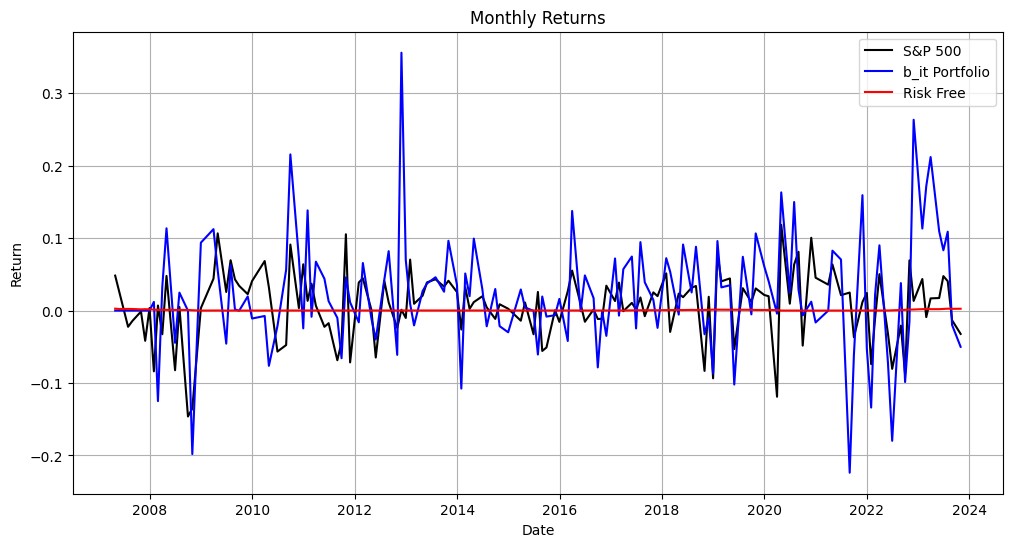

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['date'], portfolio['snp_return'], label='S&P 500', color='black')
plt.plot(portfolio['date'], portfolio['b_it_portfolio_return'], label='b_it Portfolio', color='blue')
# plt.plot(portfolio['date'], portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green')
plt.plot(portfolio['date'], portfolio['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [53]:
portfolio['log_temp_return'] = np.log1p(portfolio['b_it_portfolio_return'])
portfolio['b_it_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

# portfolio['log_temp_return'] = np.log1p(portfolio['cash_hedged_return_portfolio_return'])
# portfolio['cash_hedged_return_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

# portfolio['cash_hedged_return_portfolio_cum_return'] = (1 + portfolio['cash_hedged_return_portfolio_return']).cumprod() - 1
# portfolio['b_it_portfolio_cum_return'] = (1 + portfolio['b_it_portfolio_return']).cumprod() - 1

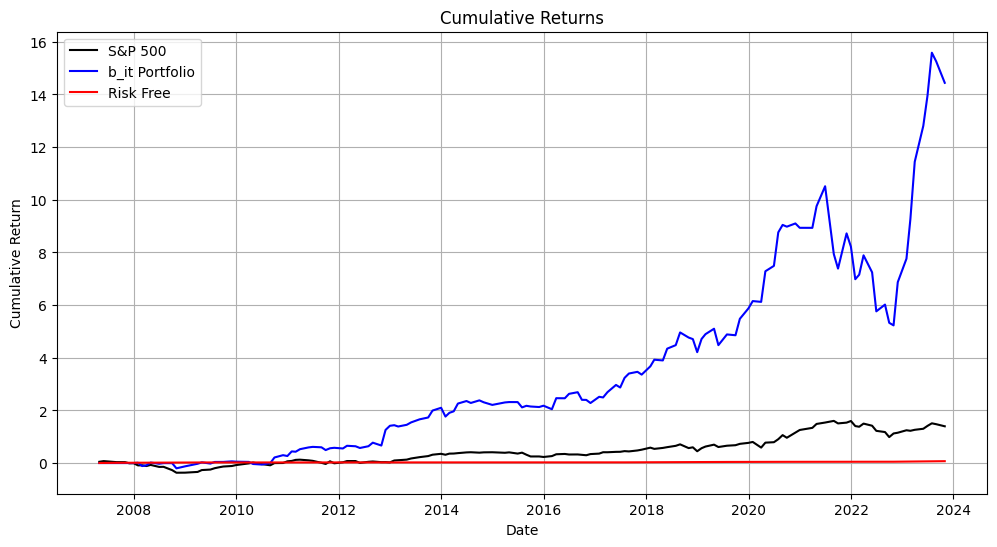

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['date'], portfolio['snp_cum_return'], label='S&P 500', color='black')
plt.plot(portfolio['date'], portfolio['b_it_portfolio_cum_return'], label='b_it Portfolio', color='blue')
# plt.plot(portfolio['date'], portfolio['cash_hedged_return_portfolio_cum_return'], label='CHR Portfolio', color='green')
plt.plot(portfolio['date'], portfolio['rf_cum_return'], label='Risk Free', color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

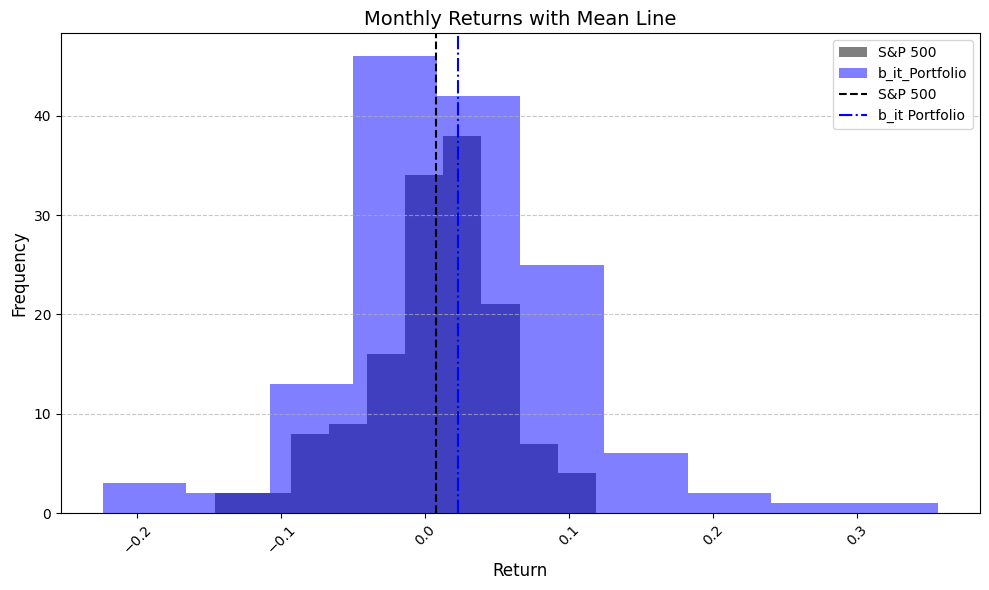

In [55]:
plt.figure(figsize=(10, 6))

plt.hist(portfolio['snp_return'], label='S&P 500', color='black', alpha=0.5)
plt.hist(portfolio['b_it_portfolio_return'], label='b_it_Portfolio', color='blue', alpha=0.5)
# plt.hist(portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green', alpha=0.5)

plt.axvline(portfolio["snp_return"].mean(), color="black", linestyle="--", label=f"S&P 500")
plt.axvline(portfolio["b_it_portfolio_return"].mean(), color="blue", linestyle="-.", label=f'b_it Portfolio')
# plt.axvline(portfolio["cash_hedged_return_portfolio_return"].mean(), color="green", linestyle="-.", label=f'CHR Portfolio')

plt.title("Monthly Returns with Mean Line", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
#plt.ylim(0, 80)
plt.show()

In [56]:
def sharpe(ret):
    excess_ret = portfolio[f"{ret}"] - portfolio["rf_rate"]
    average_excess_return = excess_ret.mean()
    std_excess_return = excess_ret.std()
    return (average_excess_return / std_excess_return) * np.sqrt(12)

print("ANNUALISED:")

pd.DataFrame(
    [
        ["SNP500" , '{0:.4f}'.format(sharpe('snp_return')), (1 + portfolio['snp_return'].mean()) ** 12 - 1, (1 + (portfolio['snp_return'].std()**2)) ** 12 - 1],
        ["b_it Portfolio" , '{0:.4f}'.format(sharpe('b_it_portfolio_return')), (1 + portfolio['b_it_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['b_it_portfolio_return'].std()**2)) ** 12 - 1]
        # ["CHR Portfolio" , '{0:.4f}'.format(sharpe('cash_hedged_return_portfolio_return')), (1 + portfolio['cash_hedged_return_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['cash_hedged_return_portfolio_return'].std()**2)) ** 12 - 1],
    ],
    columns=['Asset', 'SHARPE', 'Mean Return', 'Volatility']
)

ANNUALISED:


,Asset,SHARPE,Mean Return,Volatility
0,SNP500,0.5054,0.091448,0.026536
1,b_it Portfolio,0.9724,0.307485,0.077145
